<a href="https://colab.research.google.com/github/Sedkameni/IntroAI_Willis/blob/main/Sedrick_assignment11_IAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Dataset Selection and Preprocessing

In [ ]:
## Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2 # OpenCV library for image processing
import os # For interacting with the operating system (e.g., listing directories)
from sklearn.model_selection import train_test_split # For splitting data into training and testing sets
from sklearn.preprocessing import LabelEncoder # For encoding categorical labels into numerical ones
import zipfile # For working with zip archives

# Define the path to the zip file and the directory to extract it to
zip_path = "/content/imagesAssign11IA.zip"
extract_path = "/content/imagesAssign11IA"

# Create the extraction directory if it doesn't exist
os.makedirs(extract_path, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Dataset extracted to: {extract_path}")


# Load an image dataset (e.g., from local folder or Kaggle dataset)

data_dir = os.path.join(extract_path, 'images') # Set the data directory to the correct path within the extracted folder
categories = os.listdir(data_dir) # Get the list of categories (subfolders) in the data directory

images = [] # List to store image data
labels = [] # List to store image labels
img_size = (64, 64)  # Define a uniform size for images

# Loop through each category and load images
for category in categories:
    path = os.path.join(data_dir, category) # Create the full path to the category folder
    for img_name in os.listdir(path): # Loop through each image file in the category folder
        img = cv2.imread(os.path.join(path, img_name)) # Read the image
        if img is not None: # Check if the image was loaded successfully
            img = cv2.resize(img, img_size) # Resize the image to the uniform size
            images.append(img.flatten())  # Flatten the 2D image data to 1D and append to the list
            labels.append(category) # Append the category label to the list

X = np.array(images) # Convert the list of images to a NumPy array
y = np.array(labels) # Convert the list of labels to a NumPy array

# Normalize pixel values by dividing by 255.0
X = X / 255.0

# Encode labels using LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y) # Fit the encoder and transform the labels

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) # 80% for training, 20% for testing, stratify to maintain class distribution

Dataset extracted to: /content/imagesAssign11IA


## 2. Model Training (Random Forest with Grid Search)

In [ ]:
# Import necessary libraries for model training
from sklearn.ensemble import RandomForestClassifier # Import Random Forest Classifier
from sklearn.model_selection import GridSearchCV # Import GridSearchCV for hyperparameter tuning

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 150], # Number of trees in the forest
    'max_depth': [10, 20, None], # Maximum depth of the trees
    'min_samples_split': [2, 5, 10], # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4] # Minimum number of samples required to be at a leaf node
}

# Initialize the Random Forest Classifier
rf = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2) # Use 3-fold cross-validation, use all available cores, print progress
grid_search.fit(X_train, y_train) # Fit the grid search to the training data

# Print the best parameters found by grid search
print("Best Parameters:", grid_search.best_params_)
best_rf = grid_search.best_estimator_ # Get the best model found by grid search

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}


## 3. Model Evaluation

Accuracy: 0.7741935483870968

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.86      0.75        14
           1       0.88      0.70      0.78        10
           2       0.67      0.60      0.63        10
           3       0.75      0.55      0.63        11
           4       0.89      1.00      0.94        17

    accuracy                           0.77        62
   macro avg       0.77      0.74      0.75        62
weighted avg       0.78      0.77      0.77        62



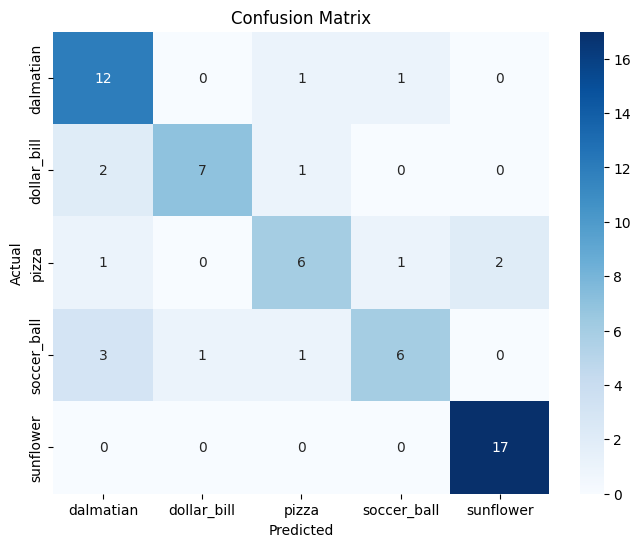

In [ ]:
# Import necessary libraries for model evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score # Import evaluation metrics
import matplotlib.pyplot as plt # Import matplotlib for plotting
import seaborn as sns # Import seaborn for enhanced visualizations

# Make predictions on the test set using the best model
y_pred = best_rf.predict(X_test)

# Print evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred)) # Print the accuracy score
print("\nClassification Report:\n", classification_report(y_test, y_pred)) # Print the classification report

# Generate and visualize the confusion matrix
cm = confusion_matrix(y_test, y_pred) # Generate the confusion matrix
plt.figure(figsize=(8,6)) # Set the figure size
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", # Create a heatmap of the confusion matrix with annotations and a blue colormap
            xticklabels=le.classes_, yticklabels=le.classes_) # Set the x and y tick labels to the original class names
plt.title("Confusion Matrix") # Set the title of the plot
plt.xlabel("Predicted") # Set the x-axis label
plt.ylabel("Actual") # Set the y-axis label
plt.show() # Display the plot

## 4. Feature Importance Visualization

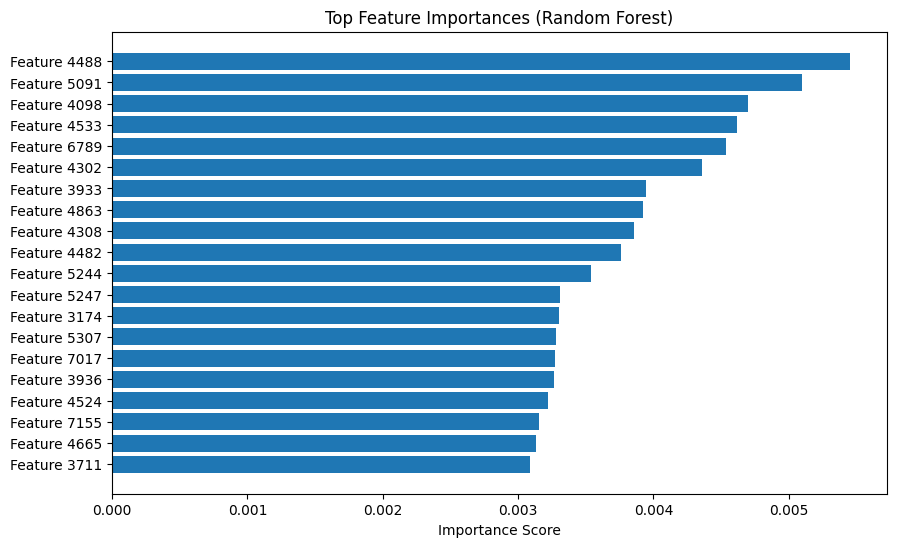

In [ ]:
# Import necessary libraries for feature importance visualization
import numpy as np # Import numpy for numerical operations
import matplotlib.pyplot as plt # Import matplotlib for plotting

# Get feature importances from the best Random Forest model
importances = best_rf.feature_importances_
indices = np.argsort(importances)[-20:]  # Get the indices of the top 20 most important features

plt.figure(figsize=(10,6)) # Set the figure size
plt.barh(range(len(indices)), importances[indices], align='center') # Create a horizontal bar plot of feature importances
plt.yticks(range(len(indices)), [f'Feature {i}' for i in indices]) # Set the y-axis ticks to indicate feature indices
plt.title("Top Feature Importances (Random Forest)") # Set the title of the plot
plt.xlabel("Importance Score") # Set the x-axis label
plt.show() # Display the plot

## 5. Prediction on New Images

In [ ]:
# Import necessary libraries for prediction on new images
import cv2 # Import OpenCV for image processing
import numpy as np # Import numpy for numerical operations

# Define a function to predict the class of a new image
def predict_new_image(image_path, model, label_encoder):
    img = cv2.imread(image_path) # Read the image from the specified path
    if img is not None: # Check if the image was loaded successfully
        img = cv2.resize(img, img_size) # Resize the image to the uniform size
        img_flat = img.flatten().reshape(1, -1) / 255.0 # Flatten the 2D image data to 1D, reshape it for prediction, and normalize pixel values
        prediction = model.predict(img_flat) # Make a prediction using the trained model
        predicted_label = label_encoder.inverse_transform(prediction) # Inverse transform the numerical prediction back to the original label
        return predicted_label[0] # Return the predicted label
    else:
        return "Error: Image not loaded." # Return an error message if the image could not be loaded

# Example usage (replace "path_to_test_image.jpg" with the actual path to your image)
new_image_path = "/content/imagesAssign11IA/images/dalmatian/image_0001.jpg" # Replace with an example image path
predicted_class = predict_new_image(new_image_path, best_rf, le) # Get the predicted class for the new image
print("Predicted Class:", predicted_class) # Print the predicted class

Predicted Class: dalmatian


## 6. Bonus: Comparison with SVM

In [ ]:
# Import necessary libraries for SVM comparison
from sklearn.svm import SVC # Import Support Vector Classifier
from sklearn.metrics import accuracy_score, classification_report # Import evaluation metrics

# Initialize and train an SVM model
svm_model = SVC(kernel='rbf', C=1, gamma='scale') # Initialize SVC with RBF kernel, C=1, and auto gamma
svm_model.fit(X_train, y_train) # Train the SVM model on the training data

# Make predictions on the test set using the SVM model
y_pred_svm = svm_model.predict(X_test)

# Print evaluation metrics for the SVM model
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm)) # Print the SVM accuracy
print("\nSVM Classification Report:\n", classification_report(y_test, y_pred_svm)) # Print the SVM classification report

# Print a summary comparison of Random Forest and SVM accuracies
print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred):.4f}") # Print Random Forest accuracy
print(f"SVM Accuracy: {accuracy_score(y_test, y_pred_svm):.4f}") # Print SVM accuracy

SVM Accuracy: 0.7096774193548387

SVM Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.79      0.61        14
           1       0.80      0.40      0.53        10
           2       0.88      0.70      0.78        10
           3       0.56      0.45      0.50        11
           4       0.94      1.00      0.97        17

    accuracy                           0.71        62
   macro avg       0.73      0.67      0.68        62
weighted avg       0.74      0.71      0.70        62

Random Forest Accuracy: 0.7742
SVM Accuracy: 0.7097


In [ ]:
import nbformat

# Path to your notebook
nb_path = "/content/Sedrick_assignment11_IAI.ipynb"

# Load the notebook
with open(nb_path, "r", encoding="utf-8") as f:
    nb = nbformat.read(f, as_version=4)

# Remove broken widget metadata
if 'widgets' in nb['metadata']:
    nb['metadata'].pop('widgets')

# Save cleaned notebook
clean_path = nb_path.replace(".ipynb", "_clean.ipynb")
with open(clean_path, "w", encoding="utf-8") as f:
    nbformat.write(nb, f)

print(" Cleaned notebook saved as:", clean_path)

 Cleaned notebook saved as: /content/Sedrick_assignment11_IAI_clean.ipynb


In [ ]:
!apt-get update
!apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic -y

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 https://cli.github.com/packages stable InRelease
Get:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:11 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [3,526 kB]
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_

In [ ]:
!jupyter nbconvert --to pdf /content/Sedrick_assignment11_IAI_clean.ipynb

[NbConvertApp] Converting notebook /content/Sedrick_assignment11_IAI_clean.ipynb to pdf
[NbConvertApp] Support files will be in Sedrick_assignment11_IAI_clean_files/
[NbConvertApp] Making directory ./Sedrick_assignment11_IAI_clean_files
[NbConvertApp] Writing 44134 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 121445 bytes to /content/Sedrick_assignment11_IAI_clean.pdf
